## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Load up the necessary packages 
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
from statsmodels.stats.proportion import proportions_ztest
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [104]:
# Define the path to our data files and the path we want to save our outputs in. 
target_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Fmr1_targets/'
ks_ecol_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
ks_dmel_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
ks_mmus_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/mmus/'
samp_num = '2'

## Calculate the KS stat of all of the genes with polyproline motifs in the E.coli data

In [107]:
# Load up the target gene names. 
PPP_table = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/data_tables/' + 'polyproline_motifs.csv')

# Load up the tables of KS statistics
df_ecol = pd.read_csv(ks_ecol_path + "ks_table_" + samp_num + ".csv")

In [108]:
# Correct the column headings and rows for the polyproline table. 
PPP_table.columns = PPP_table.iloc[2]
PPP_table = PPP_table.drop([0,1,2])

# Remove the many unecessary columns from the polyproline data
PPP_table = pd.DataFrame(PPP_table.Gene.unique(), columns = ["Gene"])

# Merge the ecoli ks table with the list of gene names
PPP_ks_table = pd.merge(df_ecol, PPP_table, how='inner', right_on='Gene', left_on='gene_ID')

In [109]:
# Several genes have multiple polyproline motifs and thus appear multiple times in the PPP table
# Keep only one copy of each gene in the PPP table. 
PPP_ks_table.sort_values("Gene", inplace = True)
PPP_ks_table.drop_duplicates(subset ="Gene",keep = "first", inplace = True) 

(0.0, 0.7)

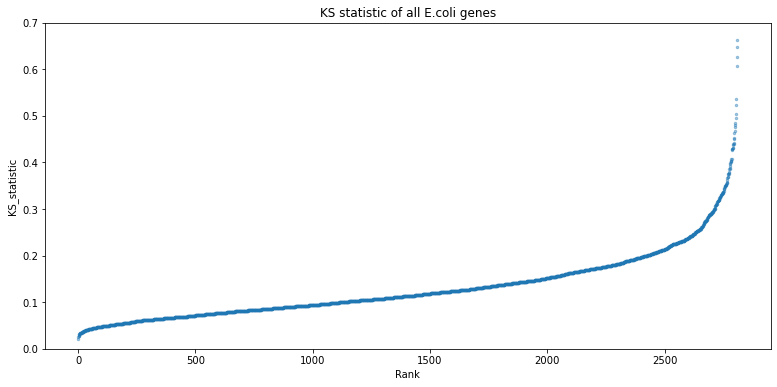

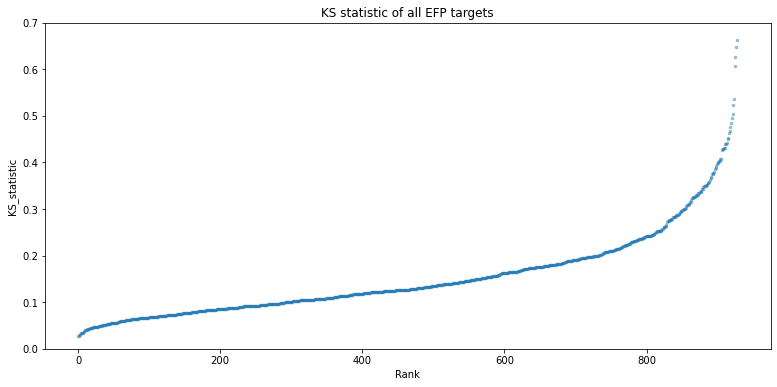

In [110]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_ecol["ks_stat"]))), sorted(df_ecol["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(PPP_ks_table["ks_stat"]))), sorted(PPP_ks_table["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all EFP targets")
plt.ylim(0,0.7)

In [111]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of EFP target genes = " + str(np.mean(PPP_ks_table.ks_stat)))
print("mean KS statistic of all E.coli genes = " + str(np.mean(df_ecol.ks_stat)))

mean KS statistic of EFP target genes = 0.15435345745861506
mean KS statistic of all E.coli genes = 0.13140164117292266


In [112]:
# Seeing what fraction of genes with the highest KS stat have polyproline motifs
len(PPP_ks_table.ks_stat[PPP_ks_table.ks_stat > 0.35])

46

In [113]:
len(df_ecol.ks_stat[df_ecol.ks_stat > 0.35])

53

In [114]:
# Use the Z test to determine if the proportion observed is significantly different from the porportion expected. 
proportions_ztest(46, 53, len(PPP_ks_table)/len(df_ecol))

(11.556160310681497, 6.8713077980540604e-31)

## Calculate the KS stat of all of the Fmr1 targets in the fly data

In [115]:
# Load up the target gene names. 
Fmr1_table = pd.read_csv(target_path + 'Fmr1_dmel_downreg_genes.txt', names = ["gene_name"])

# Load up the tables of KS statistics
df_dmel = pd.read_csv(ks_dmel_path + "ks_table_" + samp_num + ".csv")

In [116]:
# Merge the ecoli ks table with the list of gene names
Fmr1_ks_table = pd.merge(df_dmel, Fmr1_table, how='inner', right_on='gene_name', left_on='gene_ID')

In [117]:
# Keep only one copy of each gene in the Fmr1 table. 
Fmr1_ks_table.sort_values("gene_name", inplace = True)
Fmr1_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

(0.0, 0.7)

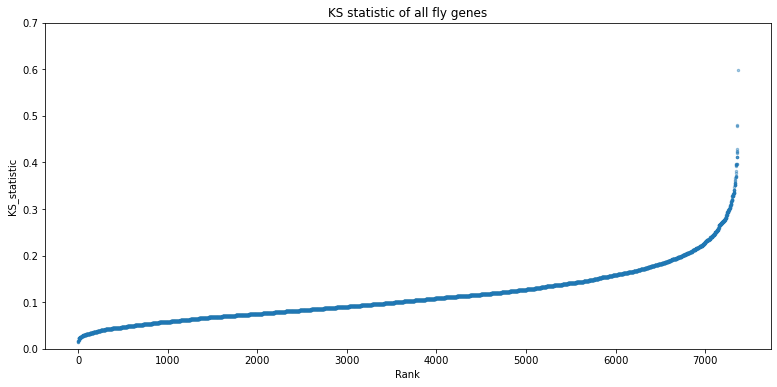

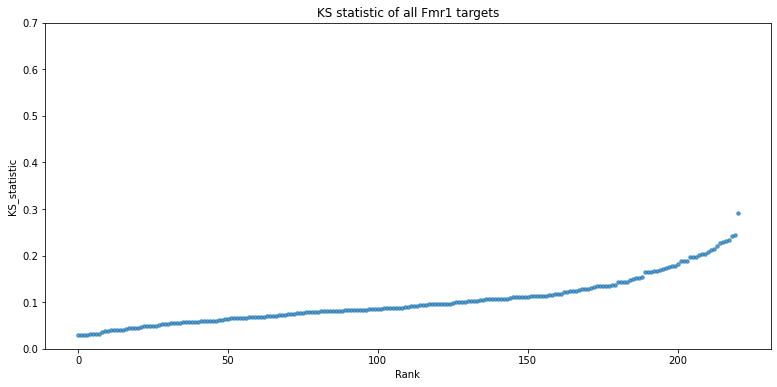

In [118]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_dmel["ks_stat"]))), sorted(df_dmel["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all fly genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(Fmr1_ks_table["ks_stat"]))), sorted(Fmr1_ks_table["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Fmr1 targets")
plt.ylim(0,0.7)

In [119]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of Fmr1 target genes = " + str(np.mean(Fmr1_ks_table.ks_stat)))
print("mean KS statistic of all D.mel genes = " + str(np.mean(df_dmel.ks_stat)))

mean KS statistic of Fmr1 target genes = 0.10195361931563798
mean KS statistic of all D.mel genes = 0.11403406133017867


In [120]:
# Expected ratio without enrichment
print(len(Fmr1_ks_table.ks_stat)/len(df_dmel.ks_stat))

# Observed ratio
print(len(Fmr1_ks_table.ks_stat[Fmr1_ks_table.ks_stat > 0.29])/len(df_dmel.ks_stat[df_dmel.ks_stat > 0.29]))

0.03002309468822171
0.00847457627118644


In [121]:
# Seeing what fraction of genes with the highest KS stat are Fmr1 targets
len(df_dmel.ks_stat[df_dmel.ks_stat > 0.29])

118

In [122]:
len(Fmr1_ks_table.ks_stat[Fmr1_ks_table.ks_stat > 0.29])

1

In [123]:
# Use the Z test to determine if the proportion observed is significantly different from the porportion expected. 
proportions_ztest(1, 118, len(Fmr1_ks_table)/len(df_dmel))

(-2.5535684001125505, 0.010662533364378673)

## Calculate the KS stat of all of the Fmr1 targets in the Mouse data

In [124]:
# Load up the target gene names. 
Fmr1_mmus_table = pd.read_csv(target_path + 'Fmr1_mmus_downreg_genes.txt', names = ["gene_name"])

# Load up the tables of KS statistics
df_mmus = pd.read_csv(ks_mmus_path + "ks_table_" + samp_num + ".csv")

In [125]:
# Merge the ecoli ks table with the list of gene names
Fmr1_mmus_ks_table = pd.merge(df_mmus, Fmr1_mmus_table, how='inner', right_on='gene_name', left_on='gene_ID')

In [126]:
# Keep only one copy of each gene in the Fmr1 table. 
Fmr1_mmus_ks_table.sort_values("gene_name", inplace = True)
Fmr1_mmus_ks_table.drop_duplicates(subset ="gene_name",keep = "first", inplace = True) 

(0.0, 0.7)

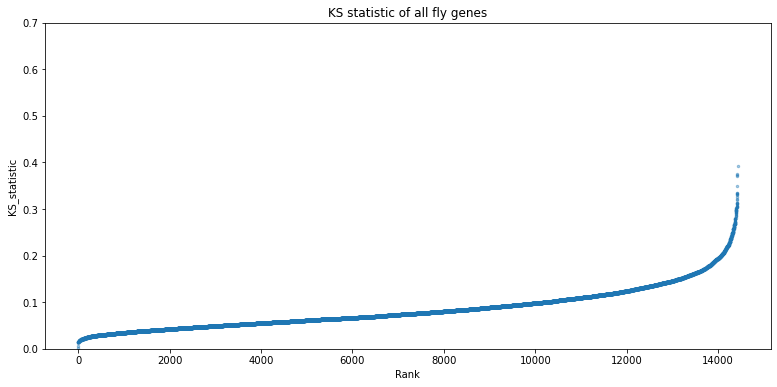

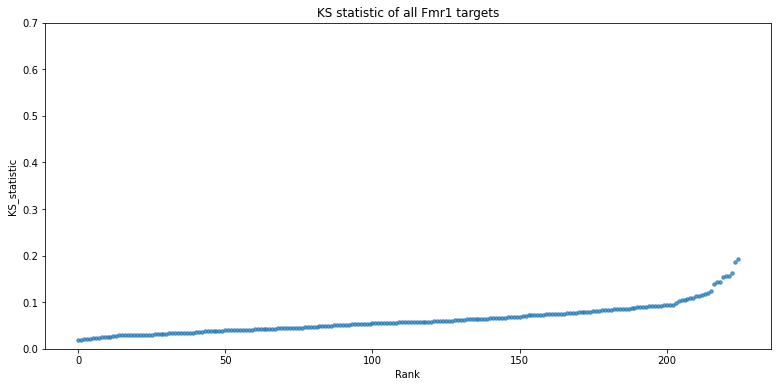

In [127]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (13,6))
plt.scatter(list(range(len(df_mmus["ks_stat"]))), sorted(df_mmus["ks_stat"]), s=6, alpha = 0.4)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all fly genes")
plt.ylim(0,0.7)
plt.show
figure(figsize = (13,6))
plt.scatter(list(range(len(Fmr1_mmus_ks_table["ks_stat"]))), sorted(Fmr1_mmus_ks_table["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all Fmr1 targets")
plt.ylim(0,0.7)

In [128]:
# print out the mean of all polyprolne motif containing genes (efp targets)
print("mean KS statistic of Fmr1 target genes = " + str(np.mean(Fmr1_mmus_ks_table.ks_stat)))
print("mean KS statistic of all D.mel genes = " + str(np.mean(df_mmus.ks_stat)))

mean KS statistic of Fmr1 target genes = 0.062437514970018794
mean KS statistic of all D.mel genes = 0.08509076059892597


In [129]:
# Expected ratio without enrichment
print(len(Fmr1_mmus_ks_table.ks_stat)/len(df_mmus.ks_stat))

# Observed ratio
print(len(Fmr1_mmus_ks_table.ks_stat[Fmr1_mmus_ks_table.ks_stat > 0.2])/len(df_mmus.ks_stat[df_mmus.ks_stat > 0.2]))

0.015600083200443735
0.0


In [132]:
# Seeing what fraction of genes with the highest KS stat are Fmr1 targets
len(df_mmus.ks_stat[df_mmus.ks_stat > 0.15])

1268

In [133]:
len(Fmr1_mmus_ks_table.ks_stat[Fmr1_mmus_ks_table.ks_stat > 0.15])

6

In [134]:
# Use the Z test to determine if the proportion observed is significantly different from the porportion expected. 
proportions_ztest(6, 1268, len(Fmr1_mmus_ks_table)/len(df_mmus))

(-5.639389335514011, 1.706542852979012e-08)

## Looking at the proportion of the targets in each KS-stat categroy

In [135]:
def split_equal(value, parts):
    value = float(value)
    return [i*value/parts for i in range(1,parts+1)]

In [136]:
def determine_enrichment(targ_ks, all_ks, N_cats, max_ks):
    ratios = []
    sections = split_equal(max_ks, N_cats)
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat < sections[0]])/len(all_ks.ks_stat[all_ks.ks_stat < sections[0]]))
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            ratios.append(len(targ_ks.ks_stat[(targ_ks.ks_stat > sec) & (targ_ks.ks_stat < sections[i+1])]
                )/len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i+1])]))
        except:
            pass
    ratios.append(len(targ_ks.ks_stat[targ_ks.ks_stat > sections[-1]])/len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]]))
    return ratios, sections

In [137]:
max_ks = 0.4
N_cats = 10
ratios_ecol, sections_ecol = determine_enrichment(PPP_ks_table, df_ecol, N_cats, max_ks)

In [138]:
sections_ecol.insert(0,0)

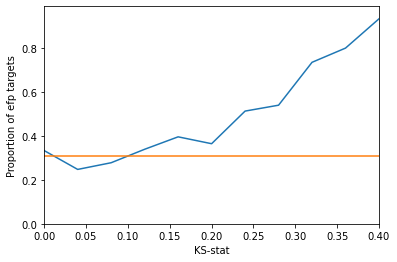

In [139]:
plt.plot(sections_ecol, ratios_ecol)
plt.xlim(0,max_ks)
plt.ylim(0, 0.99)
plt.ylabel("Proportion of efp targets")
plt.xlabel("KS-stat")
plt.plot([0,0.6],[0.31,0.31])

In [140]:
max_ks = 0.28
N_cats = 10
ratios_dmel, sections_dmel = determine_enrichment(Fmr1_ks_table, df_dmel, N_cats, max_ks)

In [141]:
sections_dmel.insert(0,0)

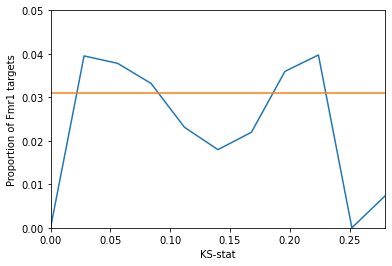

In [142]:
plt.plot(sections_dmel, ratios_dmel)
plt.xlim(0,max_ks)
plt.ylim(0, 0.05)
plt.ylabel("Proportion of Fmr1 targets")
plt.xlabel("KS-stat")
plt.plot([0,0.6],[0.031,0.031])

In [146]:
max_ks = 0.2
N_cats = 20
ratios_dmel, sections_dmel = determine_enrichment(Fmr1_mmus_ks_table, df_mmus, N_cats, max_ks)

In [147]:
sections_dmel.insert(0,0)

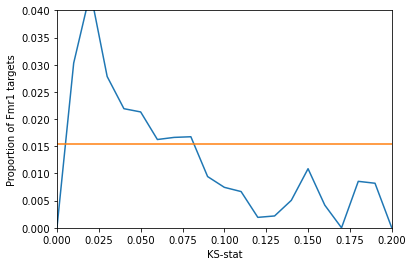

In [148]:
plt.plot(sections_dmel, ratios_dmel)
plt.xlim(0,max_ks)
plt.ylim(0, 0.04)
plt.ylabel("Proportion of Fmr1 targets")
plt.xlabel("KS-stat")
plt.plot([0,0.6],[0.0155,0.0155])

## Looking at the kernel density estimates

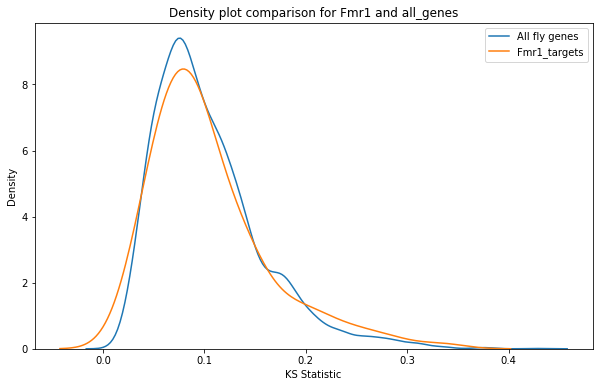

In [80]:
figure(figsize = (10,6))
sns.kdeplot(df_dmel.ks_stat, label = "All fly genes")
sns.kdeplot(Fmr1_ks_table.ks_stat, label = "Fmr1_targets")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for Fmr1 and all_genes")
plt.legend()

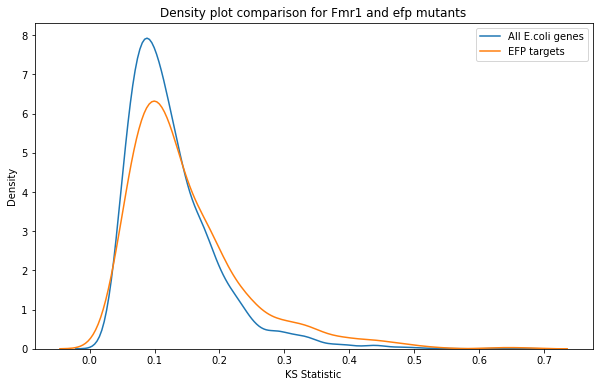

In [24]:
figure(figsize = (10,6))
sns.kdeplot(df_ecol.ks_stat, label = "All E.coli genes")
sns.kdeplot(PPP_ks_table.ks_stat, label = "EFP targets")
plt.ylabel("Density")
plt.xlabel("KS Statistic")
plt.title("Density plot comparison for Fmr1 and efp mutants")
plt.legend()

Create graphs showing the fraction of reads captured by the Fmr1 targets and efp targets as the KS-stat increases. 